# **🧪 Running LMCache with an Agent Workflow Google Colab**

This Colab notebook demonstrates how to run **LMCache** with an **Agent workflow**. We use Meta's Llama-3.1-8B-Instruct model as an example to showcase the performance impact of LMCache.


<p align="center">
  <a href="https://lmcache.ai/" style="display:inline-block; margin:0 1em; text-decoration:none;">
    <img
      src="https://raw.githubusercontent.com/LMCache/LMCache/2e4c7b95a0784babd6d61313724a801614898e1e/docs/source/assets/lmcache-logo_crop.png"
      alt="LMCache logo"
      width="170"
      style="vertical-align:middle; border:none;"
    />
  </a>
</p>

<p align="center" style="margin-top:.5em;">
  <a href="https://join.slack.com/t/lmcacheworkspace/shared_invite/zt-2viziwhue-5Amprc9k5hcIdXT7XevTaQ" style="text-decoration:none;">
    <img
      src="https://upload.wikimedia.org/wikipedia/commons/b/b9/Slack_Technologies_Logo.svg"
      alt="Slack logo"
      width="125"
      style="vertical-align:middle; margin-right: 0.5em;"
    />
  </a>
</p>

<!-- GitHub line -->
<p align="center">
  <em><b>Join Slack if you need help + ⭐ Star us on <a href="https://github.com/LMCache/LMCache" style="text-decoration:none;">GitHub</a> ⭐</b></em>
</p>



*The setup is designed to be compatible with the free GPU tier on Google Colab. You can follow along without requiring any paid compute resources.*

## ⚙️ Configure Colab Runtime

To enable GPU acceleration on Google Colab:

1. Click the **Runtime** menu in the top toolbar.
2. Select **Change runtime type**.
3. In the **Hardware accelerator** dropdown, choose **GPU** (preferably **A100 GPU**, as LMCache currently does not support the T4 GPU).
4. Click **Save**.

> 📌 You can confirm GPU access by running the following cell:
>
> ```python
> !nvidia-smi
> ```

---

## 🔐 Set Up Hugging Face Credentials

Since this demo uses **Meta’s Llama-3.1-8B-Instruct model**, you’ll need to set up your Hugging Face account and request access:

1. **Sign up** for a free account at [https://huggingface.co/join](https://huggingface.co/join).
2. **Request access** to the LLaMA 3 model here:  
   👉 [Llama-3.1-8B-Instruct Model Card](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct)  
3. Once approved, **create a Hugging Face access token**:  
   👉 [Token Settings Page](https://huggingface.co/settings/tokens)  
4. Click on the sidebar (left panel) → **"Secrets"** tab
5. Click **“+ Add new secret”**
*   Name: HF_TOKEN
*   Value: (paste your Hugging Face token)

> 💡 Your token will be used to authenticate and download the model via the Hugging Face.
>
> Access your secret keys in Python via:
>
> ```python
> from google.colab import userdata
> hf_token = userdata.get("HF_TOKEN")
> ```


## Install vLLM v1

📦 Install uv (a fast Python package manager)

In [ ]:
!curl -LsSf https://astral.sh/uv/install.sh | sh

📦 Install the latest nightly version of vLLM

In [ ]:
!uv pip install -U vllm --pre --extra-index-url https://wheels.vllm.ai/nightly

📦 Install LMCache from source

In [ ]:
!git clone https://github.com/LMCache/LMCache.git
%cd LMCache
!uv pip install .

## Download the multi‐turn QA workload scripts

Go to  
https://github.com/LMCache/LMBench/tree/main/3-workloads/synthetic  

and grab both  
- `multi-round-qa.py`  
- `utils.py`  

You can either:

1. **Manually** click “Raw” on each file and paste into new Colab editors named `multi-round-qa.py` and `utils.py`, **or**

2. **Run** this in a **Code** cell:

    ```bash
    wget https://raw.githubusercontent.com/LMCache/LMBench/main/3-workloads/synthetic/multi-round-qa.py
    wget https://raw.githubusercontent.com/LMCache/LMBench/main/3-workloads/synthetic/utils.py
    ```
    
These scripts generate the multi‐turn QA workload used below.

## Run Inference **without** LMCache

In [ ]:
from google.colab import userdata
import os

hf_token = userdata.get("HF_TOKEN")
os.environ["HF_TOKEN"] = hf_token if hf_token else ""

Start the vLLM server in the background:

In [ ]:
# launch server, backgrounded
!nohup vllm serve meta-llama/Meta-Llama-3.1-8B-Instruct \
    --port 8000 \
    --dtype float16 \
    --gpu-memory-utilization 0.9 \
    --no-enable-prefix-caching

> ⚠️ Note: This cell will keep running as long as the server is active. After you finish running the workload, **stop this cell manually** (click the stop button) to terminate the server and free the GPU.

Wait for the server to be ready. After it starts successfully, run the workload



In [ ]:
%%bash
# Simple loop to wait until /v1/chat/completions responds
echo "⏳ waiting for server to come up on port 8000…"

until curl -s localhost:8000/v1/chat/completions \
  -H "Content-Type: application/json" \
  -d '{
    "model": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "messages": [
      {
        "role": "user",
        "content": "In the heart of Eldoria, an ancient land of boundless magic and mysterious creatures, lies the long-forgotten city of Aeloria. Once a beacon of knowledge and power, Aeloria was buried beneath the shifting sands of time..."
      }
    ],
    "stream": false,
    "max_tokens": 30
  }' > /dev/null; do
  sleep 5
done

echo "✅ Server is ready!"


In [2]:
%%bash
cat << 'EOF' > run_agent_no_lmcache.sh
#!/bin/bash
if [[ $# -ne 3 ]]; then
    echo "Usage: \$0 <model> <base_url> <save_file_key>"
    exit 1
fi
MODEL=\$1
BASE_URL=\$2
KEY=\$3

# CONFIGURATION
NUM_USERS=1
NUM_ROUNDS=20
SYSTEM_PROMPT=100       # Shared system prompt length
CHAT_HISTORY=2000       # User specific chat history length
ANSWER_LEN=100          # Generation length per round
QPS=0.1                 # Single user => QPS = 0.1
OUTPUT_FILE="\${KEY}_output.csv"

python3 ./multi-round-qa.py \
    --num-users \$NUM_USERS \
    --num-rounds \$NUM_ROUNDS \
    --qps \$QPS \
    --shared-system-prompt \$SYSTEM_PROMPT \
    --user-history-prompt \$CHAT_HISTORY \
    --answer-len \$ANSWER_LEN \
    --model "\$MODEL" \
    --base-url "\$BASE_URL" \
    --output "\$OUTPUT_FILE" \
    --log-interval 30 \
    --time 100
EOF

chmod +x run_agent_no_lmcache.sh

In [ ]:
# Run workload
!bash run_agent_no_lmcache.sh \
    meta-llama/Meta-Llama-3.1-8B-Instruct \
    http://localhost:8000/v1 \
    no_lmcache

## Run Inference **with** LMCache

> ⚠️ Note: Make sure you **terminate the server and free the GPU** before continuing.

In [8]:
from google.colab import userdata
import os

hf_token = userdata.get("HF_TOKEN")
os.environ["HF_TOKEN"] = hf_token if hf_token else ""

Start the vLLM+LMCache server in the background:

In [ ]:
%%bash
export LMCACHE_CHUNK_SIZE=256
export LMCACHE_LOCAL_CPU=True
export LMCACHE_MAX_LOCAL_CPU_SIZE=5.0

# launch server, backgrounded
nohup vllm serve meta-llama/Meta-Llama-3.1-8B-Instruct \
    --port 8000 \
    --dtype float16 \
    --gpu-memory-utilization 0.9 \
    --enable-prefix-caching \
    --kv-transfer-config '{"kv_connector":"LMCacheConnectorV1","kv_role":"kv_both"}' \

> ⚠️ Note: This cell will keep running as long as the server is active. After you finish running the workload (next cell), **stop this cell manually** (click the stop button) to terminate the server and free the GPU.

Wait for the server to be ready. After it starts successfully, run the workload

In [ ]:
%%bash
# Simple loop to wait until /v1/chat/completions responds
echo "⏳ waiting for server to come up on port 8000…"

until curl -s localhost:8000/v1/chat/completions \
  -H "Content-Type: application/json" \
  -d '{
    "model": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "messages": [
      {
        "role": "user",
        "content": "In the heart of Eldoria, an ancient land of boundless magic and mysterious creatures, lies the long-forgotten city of Aeloria. Once a beacon of knowledge and power, Aeloria was buried beneath the shifting sands of time..."
      }
    ],
    "stream": false,
    "max_tokens": 30
  }' > /dev/null; do
  sleep 5
done

echo "✅ Server is ready!"


In [ ]:
%%bash
cat << 'EOF' > run_agent_lmcache.sh
#!/bin/bash
if [[ $# -ne 3 ]]; then
    echo "Usage: \$0 <model> <base_url> <save_file_key>"
    exit 1
fi
MODEL=\$1
BASE_URL=\$2
KEY=\$3

# CONFIGURATION
NUM_USERS=1
NUM_ROUNDS=20
SYSTEM_PROMPT=100       # Shared system prompt length
CHAT_HISTORY=2000       # User specific chat history length
ANSWER_LEN=100          # Generation length per round
QPS=0.1                 # Queries/s
OUTPUT_FILE="\${KEY}_output.csv"

python3 ./multi-round-qa.py \
    --num-users \$NUM_USERS \
    --num-rounds \$NUM_ROUNDS \
    --qps \$QPS \
    --shared-system-prompt \$SYSTEM_PROMPT \
    --user-history-prompt \$CHAT_HISTORY \
    --answer-len \$ANSWER_LEN \
    --model "\$MODEL" \
    --base-url "\$BASE_URL" \
    --output "\$OUTPUT_FILE" \
    --log-interval 30 \
    --time 100
EOF

chmod +x run_agent_lmcache.sh

In [ ]:
# Run workload
!bash run_agent_lmcache.sh \
    meta-llama/Meta-Llama-3.1-8B-Instruct \
    http://localhost:8000/v1 \
    lmcache

> 💡 When comparing no_lmcache.csv with lmcache.csv, you can see that LMCache's time-to-first-token (TTFT) improves dramatically after the first round. Below is an example:

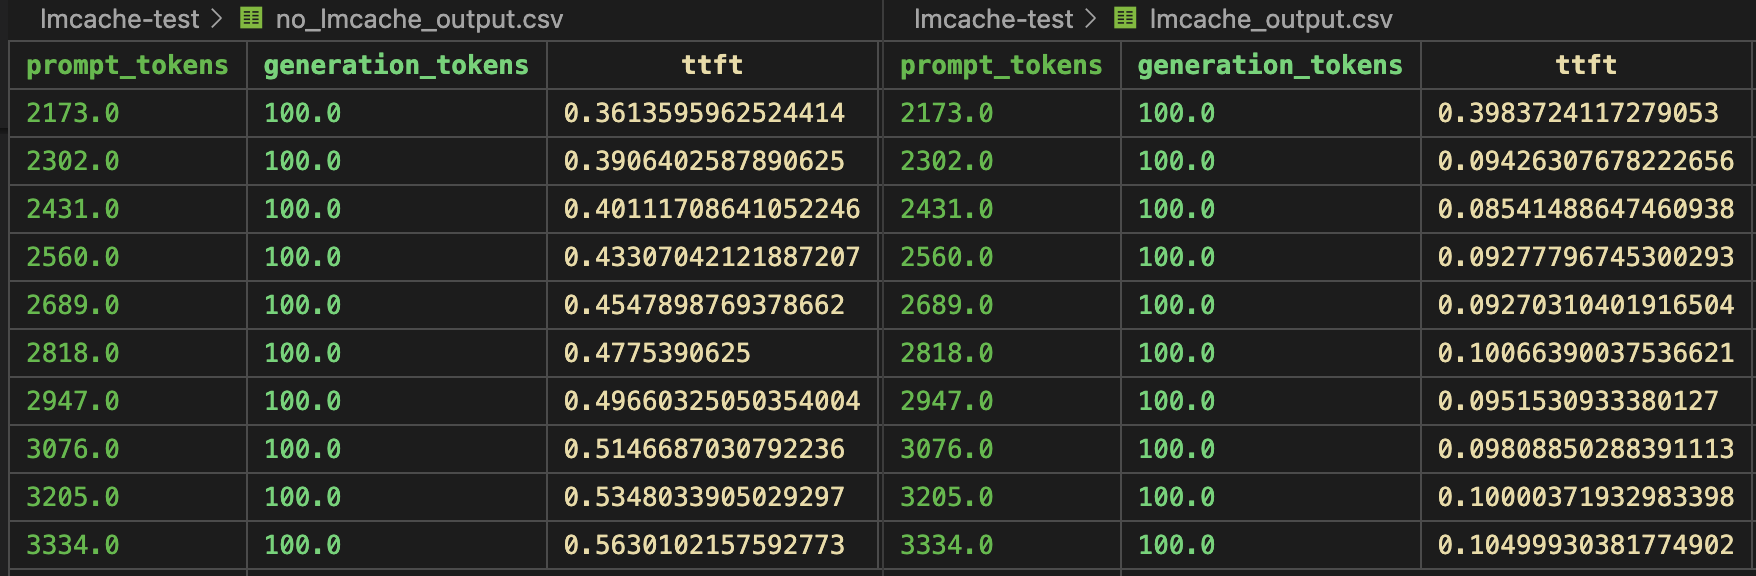
